In [1]:
import numpy as np
import pandas as pd
from rich import print
import json
import matplotlib.pyplot as plt
import trove

# Discovering Error-Inducing Static Feature Biases with TRoVe
In this notebook, we demonstrate how TRoVe can be utilized to identify error-inducing static feature biases learned by temporal vision-language models (VLMs).

## Step 1: Load validation dataset with VLM predictions
First, we obtain a validation dataset associated with a temporal understanding task. In this demo, we consider a subset of the Kinetics400 validation set consisting of 498 videos, each represented as a sequence of image frames. Sequences are paired with one of ten class labels indicating the depicted human activity. For each sequence, we compute embeddings and classification logits using an off-the-shelf temporal VLM. 

We provide a Pandas dataframe consisting of the validation dataset with associated VLM predictions in `data/sample_data.pkl`. The columns of this dataframe include: 
- `filepath`: Filepath of the video, as found in the original Kinetics400 validation dataset
- `label`: Activity recognition class label
- `sequence_embs`: Embedding for the entire sequence, generated using the temporal VLM. The sequence embedding is expressed as a vector of size 768.
- `sequence_probs`: Post-softmax probabilities when classifying the sequence using the temporal VLM. Probabilities have been calibrated using temperature scaling and are expressed as a vector of size 10.
- `image_embs`: Embeddings for each individual image in the sequence, generated using the temporal VLM. Image embeddings are expressed as a matrix of size (8,768).
- `image_probs`: Post-softmax probabilities when individually classifying each image in the sequence using the temporal VLM. Probabilities have been calibrated using temperature scaling and are expressed as a matrix of size (8,10).

In [2]:
DATA_DIR = 'data/'
DATA_ID = 'sample_data'

In [3]:
df = pd.read_pickle(f"{DATA_DIR}/{DATA_ID}.pkl")
print(f"Loaded dataframe of shape: {df.shape}")
df.head()

Loaded dataframe of shape: (498, 6)

,filepath,label,sequence_embs,sequence_probs,image_embs,image_probs
0,val/rock_climbing/cnnFk5xWIQc_000075_000085.mp4,rock climbing,"[0.0023674222, -0.053341985, 0.0030801941, 0.0...","[0.9669866055021711, 0.0010894374830477183, 0....","[[-0.015903017, -0.011666936, -0.011578642, -0...","[[0.92656183, 0.002146582, 0.06539685, 0.00112..."
1,val/rock_climbing/Nkl-S91V2Ms_000314_000324.mp4,rock climbing,"[0.031229876, 0.038693182, 0.035528563, 0.0152...","[0.22497798890695125, 0.0012290695841629324, 0...","[[0.007049077, 0.031106366, 0.045863874, 0.013...","[[0.40737492, 0.001989456, 0.545852, 0.0014727..."
2,val/rock_climbing/2jXlO2nzHGE_000026_000036.mp4,rock climbing,"[0.0083572315, -0.030565413, -0.015407001, 0.0...","[0.8119105691789763, 0.002443737687055374, 0.1...","[[0.011186437, -0.02051917, -0.030067416, 0.02...","[[0.82089686, 0.0015954901, 0.17140716, 0.0006..."
3,val/rock_climbing/_Sam59CH5_o_000214_000224.mp4,rock climbing,"[-0.029091943, -0.019530145, 0.020383589, 0.04...","[0.9266434141896537, 0.003948797210906809, 0.0...","[[-0.044684477, 0.002719537, 0.029004995, 0.03...","[[0.35111976, 0.046852235, 0.24660768, 0.00878..."
4,val/rock_climbing/s5jxkWFe0WI_000006_000016.mp4,rock climbing,"[0.010857561, -0.010189501, -0.030244114, 0.03...","[0.946509061778893, 0.0027180166753679874, 0.0...","[[-0.009999444, 0.006695609, 0.008499215, 0.04...","[[0.21216181, 0.008170098, 0.09364317, 0.05201..."


In [4]:
with open(f"{DATA_DIR}/{DATA_ID}.json", "r") as f: 
    metadata = json.load(f)
class_labels = metadata['class_labels']
print(f"Class Labels: {class_labels}\n")

Class Labels: ['rock climbing', 'sticking tongue out', 'climbing tree', 'crawling baby', 'eating cake', 
'motorcycling', 'sneezing', 'scuba diving', 'swinging on something', 'knitting']

## Step 2: Compute classification accuracy of temporal VLM
We compute overall sequence-level classification accuracy on the validation dataset.

In [5]:
top_1_pred = df['sequence_probs'].apply(lambda x: x.argmax())
label = df['label'].apply(lambda x: class_labels.index(x))

cls_acc = (top_1_pred == label).mean()
print(f"Overall Sequence-Level Classification Accuracy: {np.round(cls_acc*100, 3)}\n")

Overall Sequence-Level Classification Accuracy: 82.329

## Step 3: Run TRoVe
Although the temporal VLM exhibits high overall performance, it may be relying on the presence of static feature biases when making predictions. Reliance on static feature biases can lead to systematic prediction errors at test time on important subgroups of data. We now run TRoVe in order to determine whether the temporal VLM is affected by error-inducing static feature biases.

In [6]:
out = trove.score(df, class_labels)

=> Starting TRoVe - Step 1: Extract candidate static features


Running FAISS Spherical K-Means with [20 30 40 50] clusters

Clustering 3984 points in 768D to 20 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.12 s, search 0.11 s): objective=3294.14 imbalance=1.302 nsplit=0       
Clustering 3984 points in 768D to 30 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.28 s, search 0.16 s): objective=3323.57 imbalance=1.689 nsplit=0       
Clustering 3984 points in 768D to 40 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.16 s, search 0.15 s): objective=3359.01 imbalance=1.521 nsplit=0       
Clustering 3984 points in 768D to 50 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.19 s, search 0.19 s): objective=3378.82 imbalance=1.606 nsplit=0       


+----------+------------+
| clusters | silhouette |
+----------+------------+
|    20    |   0.151    |
|    30    |   0.156    |
|    40    |    0.13    |
|    50    |   0.139    |
+----------+------------+

Selected 30 clusters

=> Starting TRoVe - Step 2: Discover error-inducing static feature biases
=> Completed execution


## Step 4: Analyze Results
We will now analyze the output of TRoVe. In order to run the following code, please download the Kinetics400 validation set and store in `data/kinetics400/`.

First, let's count the number of static feature biases identified by TRoVe:

In [7]:
for cls_label in out:
    if len(out[cls_label]) == 0: continue
    print(f"The VLM makes prediction errors on class label \"{cls_label}\" due to {len(out[cls_label])} learned static feature bias(es).")


The VLM makes prediction errors on class label "sticking tongue out" due to 1 learned static feature bias(es).

The VLM makes prediction errors on class label "eating cake" due to 1 learned static feature bias(es).

The VLM makes prediction errors on class label "sneezing" due to 1 learned static feature bias(es).

The VLM makes prediction errors on class label "swinging on something" due to 2 learned static feature bias(es).

Let's take a look at a learned static feature bias affecting performance on the class label `sticking tongue out`.

Error Contribution Score: 0.3566433566433566

Static Bias Score: 0.6461065

TRoVe Score: 1.0027498381954807

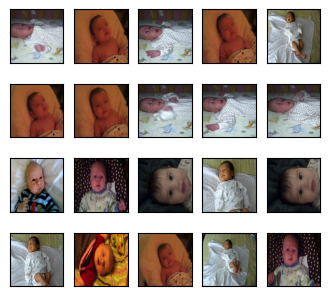

In [8]:
cls_label = 'sticking tongue out'
print("Error Contribution Score:", out[cls_label][0]['ec_score'])
print("Static Bias Score:", out[cls_label][0]['sb_score'])
print("TRoVe Score:", out[cls_label][0]['trove_score'])

top_images = []
for image_idx in out[cls_label][0]['ranked_image_idx'][:20]:
    frame = trove.utils.load_frame_from_video(df, image_idx, DATA_DIR)    
    top_images.append(frame)

fig, axes = plt.subplots(4, 5, figsize=(4, 3)) 
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.05, wspace=0.2)
for j, pixel_data in enumerate(top_images): 
      axes[j//5, j%5].imshow(top_images[j])
      axes[j//5, j%5].get_xaxis().set_visible(False)
      axes[j//5, j%5].get_yaxis().set_visible(False)
plt.show()



Here, TRoVe surfaces a feature cluster consisting of babies; this suggests that when static features associated with babies are present in a sequence, the VLM is likely to exhibit degraded performance on the class `sticking tongue out`.

Next, let's take a look at a learned static feature bias affecting performance on the class label `swinging on something`.

Error Contribution Score: 0.4423076923076923

Static Bias Score: 0.7117835

TRoVe Score: 1.1540912206356342

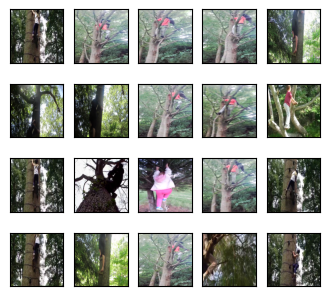

In [9]:
cls_label = 'swinging on something'
print("Error Contribution Score:", out[cls_label][0]['ec_score'])
print("Static Bias Score:", out[cls_label][0]['sb_score'])
print("TRoVe Score:", out[cls_label][0]['trove_score'])

top_images = []
for image_idx in out[cls_label][0]['ranked_image_idx'][:20]:
    frame = trove.utils.load_frame_from_video(df, image_idx, DATA_DIR)    
    top_images.append(frame)

fig, axes = plt.subplots(4, 5, figsize=(4, 3)) 
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.05, wspace=0.2)
for j, pixel_data in enumerate(top_images): 
      axes[j//5, j%5].imshow(top_images[j])
      axes[j//5, j%5].get_xaxis().set_visible(False)
      axes[j//5, j%5].get_yaxis().set_visible(False)
plt.show()

Here, TRoVe surfaces a feature cluster consisting of trees; this suggests that when static features associated with trees are present in a sequence, the VLM is likely to exhibit degraded performance on the class `swinging on something`.